In [1]:
!pip install swifter

In [2]:
#Important imports to be added

import pandas as pd
import numpy as np
import re,nltk,swifter
import matplotlib.pyplot as plt
import seaborn as sn
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import tree
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')


In [3]:
import nltk
#downloading stopwords library from nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
#reading csv and filling out missing values
df = pd.read_csv(r'/content/train-balanced-sarcasm.csv')
# Sample 150,000 random rows
df = df.sample(n=25000, random_state=42)
df = df.fillna('')

In [5]:
#taking only necessary comments
df = df[['label','comment','author','score','created_utc','parent_comment']]

In [6]:
df.head()

,label,comment,author,score,created_utc,parent_comment
608627,1,And he sure as hell is successful!,armiechedon,1,2015-12-09 23:41:48,Obama's smoked before? Or at least admitted it?
456977,1,"wait, you have to win the candidates to challe...",killingfeels,1,2016-02-13 00:04:43,You can say the same thing about any chess pla...
803801,1,I mean how could anyone not see that it is ant...,Gnofar,5,2014-12-25 21:59:49,That isn't Hanako?
926708,0,"Funny thing, most of the girl pants I've bough...",smischmal,2,2012-03-05 02:03:43,Girl Pants (X/post from TwoXChromosomes)
129279,0,"Also Ranch dressing, because LBJ was Texan, an...",ElScreecho,28,2016-09-19 19:20:53,Lyndon Johnson salad: A carrot and 2 beetroots...


**Exploratory Data Analysis**

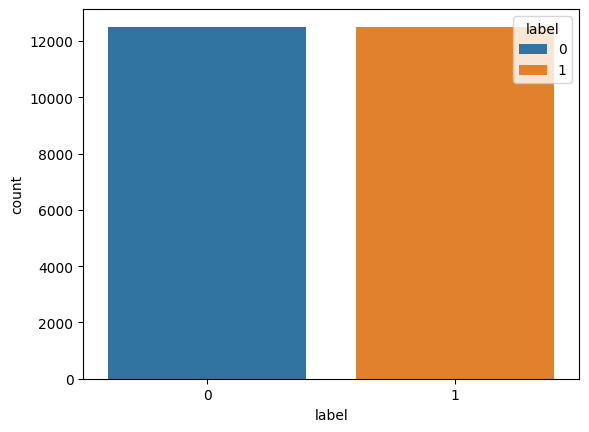

The percentage of Non-Sarcastic comments is 50.024
The percentage of Sarcastic comments is 49.976


In [7]:
import seaborn as sns
sns.countplot(x="label",data=df,hue="label")
plt.show()
print("The percentage of Non-Sarcastic comments is",sum(df['label']==0)/(len(df['label']))*100)
print("The percentage of Sarcastic comments is",sum(df['label']==1)/(len(df['label']))*100)

We can see from the countplot that this dataset is balanced

In [8]:
def clean_text(comment):

    # Cleaning the text by removing links, usernames, HTML tags, expansion of words, username removal, etc.
    text = str(comment)

    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', text)

    # Remove HTML tags
    text = re.sub("<.*?>", " ", text)

    # Remove numbers
    text = re.sub(r"[0-9]+", " ", text)

    # Remove reddit handles
    text = re.sub(r"@[A-Za-z0-9]+", " ", text)

    # Replace contractions
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)

    # Remove special characters
    text = text.replace('\\r', ' ')
    text = text.replace('\\"', ' ')
    text = text.replace('\\n', ' ')

    return text

# Apply text cleaning
df["cleanV1_comment"] = df["comment"].apply(clean_text)


In [9]:
df.head(5)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment
608627,1,And he sure as hell is successful!,armiechedon,1,2015-12-09 23:41:48,Obama's smoked before? Or at least admitted it?,And he sure as hell is successful!
456977,1,"wait, you have to win the candidates to challe...",killingfeels,1,2016-02-13 00:04:43,You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe..."
803801,1,I mean how could anyone not see that it is ant...,Gnofar,5,2014-12-25 21:59:49,That isn't Hanako?,I mean how could anyone not see that it is ant...
926708,0,"Funny thing, most of the girl pants I've bough...",smischmal,2,2012-03-05 02:03:43,Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou..."
129279,0,"Also Ranch dressing, because LBJ was Texan, an...",ElScreecho,28,2016-09-19 19:20:53,Lyndon Johnson salad: A carrot and 2 beetroots...,"Also Ranch dressing, because LBJ was Texan, an..."


In [10]:
#function to lowercase all except all caps word
def lowercase_except_caps(sentence):
  #print(sentence)
  words = sentence.split()
  modified_words = []
  for word in words:
    if word.isupper():
      modified_words.append(word)
    else:
      modified_words.append(word.lower())
  return " ".join(modified_words)

**Abbreviation Replacement**


In [11]:
#csv to dataframe
abbrslang=pd.read_csv(r'/content/Abbr_Slang_Final.csv')
abbrslang

,Abbr/Slang,Meaning
0,@TEOTD,At the end of the day
1,143,I love you
2,2G2BT,Too good to be true
3,404,I don't know
4,4EAE,Forever and ever
...,...,...
450,BS,Bullshit
451,NYC,New York City
452,VR,Virtual Reality
453,GTA,Grand Theft Auto


In [12]:
abbrslangDict=abbrslang.to_dict(orient='records')
abbrslangDict

[{'Abbr/Slang': '@TEOTD', 'Meaning': 'At the end of the day'},
 {'Abbr/Slang': '143', 'Meaning': 'I love you'},
 {'Abbr/Slang': '2G2BT', 'Meaning': 'Too good to be true'},
 {'Abbr/Slang': '404', 'Meaning': "I don't know"},
 {'Abbr/Slang': '4EAE', 'Meaning': 'Forever and ever'},
 {'Abbr/Slang': 'A3', 'Meaning': 'Anytime, anywhere, anyplace'},
 {'Abbr/Slang': 'AAF', 'Meaning': 'As a matter of fact'},
 {'Abbr/Slang': 'AAK', 'Meaning': 'Asleep at keyboard'},
 {'Abbr/Slang': 'AAMOI', 'Meaning': 'As a matter of interest'},
 {'Abbr/Slang': 'AAP', 'Meaning': 'Always a pleasure'},
 {'Abbr/Slang': 'AAR', 'Meaning': 'At any rate'},
 {'Abbr/Slang': 'AAS', 'Meaning': 'Alive and smiling'},
 {'Abbr/Slang': 'ACK', 'Meaning': 'Acknowledge'},
 {'Abbr/Slang': 'ADD', 'Meaning': 'Address'},
 {'Abbr/Slang': 'ADN', 'Meaning': 'Any day now'},
 {'Abbr/Slang': 'ADR', 'Meaning': 'Address'},
 {'Abbr/Slang': 'AEAP', 'Meaning': 'As early as possible'},
 {'Abbr/Slang': 'AFAIK', 'Meaning': 'As far as I know'},
 {'Abb

In [13]:
import re
def expand_abbr(text, abbr_dict):
    # Regex for 2 or more capital letters (excluding common abbreviations)
    pattern1 = r"\b([A-Z]{2,}(?!\.[A-Z]{2,}))\b"

    # Regex for common abbreviations (Mr., Mrs., etc.)
    pattern2 = r"\b([A-Z]{2,}\.?)\b"

    # Combine both patterns
    combined_pattern = re.compile("|".join([pattern1, pattern2]))

    detected_abbr = []  # List to store detected abbreviations

    def expand_match(match):
        matched_abbr = match.group()
        detected_abbr.append(matched_abbr)  # Store detected abbreviation
        for entry in abbr_dict:
            if matched_abbr.upper() == entry['Abbr/Slang']:
                return entry['Meaning']
        return matched_abbr  # Use default if not found

    if not isinstance(text, str):
        text = str(text)  # Convert non-string inputs to strings

    expanded_text = combined_pattern.sub(expand_match, text)

    return expanded_text, detected_abbr

df['abbr_comment'], df['detected_abbr'] = zip(*df['cleanV1_comment'].apply(expand_abbr, args=(abbrslangDict,)))
df.head(5)


,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,abbr_comment,detected_abbr
608627,1,And he sure as hell is successful!,armiechedon,1,2015-12-09 23:41:48,Obama's smoked before? Or at least admitted it?,And he sure as hell is successful!,And he sure as hell is successful!,[]
456977,1,"wait, you have to win the candidates to challe...",killingfeels,1,2016-02-13 00:04:43,You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe...","wait, you have to win the candidates to challe...",[]
803801,1,I mean how could anyone not see that it is ant...,Gnofar,5,2014-12-25 21:59:49,That isn't Hanako?,I mean how could anyone not see that it is ant...,I mean how could anyone not see that it is ant...,[]
926708,0,"Funny thing, most of the girl pants I've bough...",smischmal,2,2012-03-05 02:03:43,Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou...","Funny thing, most of the girl pants I have bou...",[]
129279,0,"Also Ranch dressing, because LBJ was Texan, an...",ElScreecho,28,2016-09-19 19:20:53,Lyndon Johnson salad: A carrot and 2 beetroots...,"Also Ranch dressing, because LBJ was Texan, an...","Also Ranch dressing, because LBJ was Texan, an...",[LBJ]


In [14]:
from collections import Counter
import pandas as pd

# Flatten the list of lists into a single list
detected_abbr_flat = [word for sublist in df['detected_abbr'] if sublist for word in sublist]

# Count the frequency of each word
word_freq = Counter(detected_abbr_flat)

# Convert the Counter object to a DataFrame
word_freq_df = pd.DataFrame.from_dict(word_freq, orient='index', columns=['Frequency'])

# Sort the DataFrame by frequency in descending order
word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)

# Save the DataFrame to a CSV file
word_freq_df.to_csv('word_frequency.csv')


In [15]:
df.to_csv('log1.csv', index=False)

In [16]:
df.head(5)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,abbr_comment,detected_abbr
608627,1,And he sure as hell is successful!,armiechedon,1,2015-12-09 23:41:48,Obama's smoked before? Or at least admitted it?,And he sure as hell is successful!,And he sure as hell is successful!,[]
456977,1,"wait, you have to win the candidates to challe...",killingfeels,1,2016-02-13 00:04:43,You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe...","wait, you have to win the candidates to challe...",[]
803801,1,I mean how could anyone not see that it is ant...,Gnofar,5,2014-12-25 21:59:49,That isn't Hanako?,I mean how could anyone not see that it is ant...,I mean how could anyone not see that it is ant...,[]
926708,0,"Funny thing, most of the girl pants I've bough...",smischmal,2,2012-03-05 02:03:43,Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou...","Funny thing, most of the girl pants I have bou...",[]
129279,0,"Also Ranch dressing, because LBJ was Texan, an...",ElScreecho,28,2016-09-19 19:20:53,Lyndon Johnson salad: A carrot and 2 beetroots...,"Also Ranch dressing, because LBJ was Texan, an...","Also Ranch dressing, because LBJ was Texan, an...",[LBJ]


In [17]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
from nltk.tokenize import word_tokenize
import string

# Remove punctuation marks
df['punct_abbr_comment'] = df['abbr_comment'].apply(lambda x: ''.join([char for char in x if char not in string.punctuation or char in ['?', '!','...']]))
# Tokenize the text
df['tokenized_abbr_comment'] = df['punct_abbr_comment'].apply(lambda x: word_tokenize(x))


In [19]:
df.head(5)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,abbr_comment,detected_abbr,punct_abbr_comment,tokenized_abbr_comment
608627,1,And he sure as hell is successful!,armiechedon,1,2015-12-09 23:41:48,Obama's smoked before? Or at least admitted it?,And he sure as hell is successful!,And he sure as hell is successful!,[],And he sure as hell is successful!,"[And, he, sure, as, hell, is, successful, !]"
456977,1,"wait, you have to win the candidates to challe...",killingfeels,1,2016-02-13 00:04:43,You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe...","wait, you have to win the candidates to challe...",[],wait you have to win the candidates to challen...,"[wait, you, have, to, win, the, candidates, to..."
803801,1,I mean how could anyone not see that it is ant...,Gnofar,5,2014-12-25 21:59:49,That isn't Hanako?,I mean how could anyone not see that it is ant...,I mean how could anyone not see that it is ant...,[],I mean how could anyone not see that it is ant...,"[I, mean, how, could, anyone, not, see, that, ..."
926708,0,"Funny thing, most of the girl pants I've bough...",smischmal,2,2012-03-05 02:03:43,Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou...","Funny thing, most of the girl pants I have bou...",[],Funny thing most of the girl pants I have boug...,"[Funny, thing, most, of, the, girl, pants, I, ..."
129279,0,"Also Ranch dressing, because LBJ was Texan, an...",ElScreecho,28,2016-09-19 19:20:53,Lyndon Johnson salad: A carrot and 2 beetroots...,"Also Ranch dressing, because LBJ was Texan, an...","Also Ranch dressing, because LBJ was Texan, an...",[LBJ],Also Ranch dressing because LBJ was Texan and ...,"[Also, Ranch, dressing, because, LBJ, was, Tex..."


In [20]:
!pip install emoji

In [21]:
import emoji
# Function to check if a string contains emojis
def has_emoji(text):
    #text = str(text)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return bool(emoji_pattern.search(text))

# Function to replace emojis with their meanings
def replace_emojis(text):
    return emoji.demojize(text)

# Apply emoji replacement and check for emojis
df["has_emoji"] = df["tokenized_abbr_comment"].astype(str).apply(has_emoji)
# df["emoji_replaced_comment"] = df["tokenized_abbr_comment"].astype(str).apply(replace_emojis)

# Apply emoji replacement and create a pandas Series
emoji_replaced_series = df["tokenized_abbr_comment"].astype(str).apply(replace_emojis)

# Assign the pandas Series to the DataFrame as a new column
df["emoji_replaced_comment"] = emoji_replaced_series
print(type(df['emoji_replaced_comment']))



<class 'pandas.core.series.Series'>


In [22]:
df['has_emoji'].value_counts()[False]

25000

**This upper value is same as the total number of comments, which shows that we don't have any emojis in the dataset**

In [23]:
df.head(5)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,abbr_comment,detected_abbr,punct_abbr_comment,tokenized_abbr_comment,has_emoji,emoji_replaced_comment
608627,1,And he sure as hell is successful!,armiechedon,1,2015-12-09 23:41:48,Obama's smoked before? Or at least admitted it?,And he sure as hell is successful!,And he sure as hell is successful!,[],And he sure as hell is successful!,"[And, he, sure, as, hell, is, successful, !]",False,"['And', 'he', 'sure', 'as', 'hell', 'is', 'suc..."
456977,1,"wait, you have to win the candidates to challe...",killingfeels,1,2016-02-13 00:04:43,You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe...","wait, you have to win the candidates to challe...",[],wait you have to win the candidates to challen...,"[wait, you, have, to, win, the, candidates, to...",False,"['wait', 'you', 'have', 'to', 'win', 'the', 'c..."
803801,1,I mean how could anyone not see that it is ant...,Gnofar,5,2014-12-25 21:59:49,That isn't Hanako?,I mean how could anyone not see that it is ant...,I mean how could anyone not see that it is ant...,[],I mean how could anyone not see that it is ant...,"[I, mean, how, could, anyone, not, see, that, ...",False,"['I', 'mean', 'how', 'could', 'anyone', 'not',..."
926708,0,"Funny thing, most of the girl pants I've bough...",smischmal,2,2012-03-05 02:03:43,Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou...","Funny thing, most of the girl pants I have bou...",[],Funny thing most of the girl pants I have boug...,"[Funny, thing, most, of, the, girl, pants, I, ...",False,"['Funny', 'thing', 'most', 'of', 'the', 'girl'..."
129279,0,"Also Ranch dressing, because LBJ was Texan, an...",ElScreecho,28,2016-09-19 19:20:53,Lyndon Johnson salad: A carrot and 2 beetroots...,"Also Ranch dressing, because LBJ was Texan, an...","Also Ranch dressing, because LBJ was Texan, an...",[LBJ],Also Ranch dressing because LBJ was Texan and ...,"[Also, Ranch, dressing, because, LBJ, was, Tex...",False,"['Also', 'Ranch', 'dressing', 'because', 'LBJ'..."


**Stop words removal**

In [24]:
# import ast
# from nltk.tokenize import word_tokenize
# #removing some important stopwords for sarcasm detection
# stops = set(stopwords.words('english')) - {'no','not','nor','against','above','below','off','own'}

# def stop_text(comment):
#     # Join the list elements into a single string
#     comment_str = ' '.join(comment)
#     # Remove stopwords
#     cleaned_words = [word for word in comment_str.split() if word.lower() not in stops]
#     # Join the cleaned words back into a single string
#     cleaned_text = ''.join(cleaned_words)
#     return cleaned_text


# # Apply text cleaning
# df["cleaned_comment"] = df["emoji_replaced_comment"].apply(stop_text)

import ast
from nltk.corpus import stopwords

# Import stopwords and define custom set
stops = set(stopwords.words('english')) - {'no', 'not', 'nor', 'against', 'above', 'below', 'off', 'own'}

# Apply stopword removal to the emoji_replaced_comment column
def remove_stopwords(comment):
    return [word for word in ast.literal_eval(comment) if word.lower() not in stops]

df["cleaned_comment"] = df["emoji_replaced_comment"].apply(remove_stopwords)








In [25]:
df.head(5)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,abbr_comment,detected_abbr,punct_abbr_comment,tokenized_abbr_comment,has_emoji,emoji_replaced_comment,cleaned_comment
608627,1,And he sure as hell is successful!,armiechedon,1,2015-12-09 23:41:48,Obama's smoked before? Or at least admitted it?,And he sure as hell is successful!,And he sure as hell is successful!,[],And he sure as hell is successful!,"[And, he, sure, as, hell, is, successful, !]",False,"['And', 'he', 'sure', 'as', 'hell', 'is', 'suc...","[sure, hell, successful, !]"
456977,1,"wait, you have to win the candidates to challe...",killingfeels,1,2016-02-13 00:04:43,You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe...","wait, you have to win the candidates to challe...",[],wait you have to win the candidates to challen...,"[wait, you, have, to, win, the, candidates, to...",False,"['wait', 'you', 'have', 'to', 'win', 'the', 'c...","[wait, win, candidates, challenge, world, titl..."
803801,1,I mean how could anyone not see that it is ant...,Gnofar,5,2014-12-25 21:59:49,That isn't Hanako?,I mean how could anyone not see that it is ant...,I mean how could anyone not see that it is ant...,[],I mean how could anyone not see that it is ant...,"[I, mean, how, could, anyone, not, see, that, ...",False,"['I', 'mean', 'how', 'could', 'anyone', 'not',...","[mean, could, anyone, not, see, antique, shopguy]"
926708,0,"Funny thing, most of the girl pants I've bough...",smischmal,2,2012-03-05 02:03:43,Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou...","Funny thing, most of the girl pants I have bou...",[],Funny thing most of the girl pants I have boug...,"[Funny, thing, most, of, the, girl, pants, I, ...",False,"['Funny', 'thing', 'most', 'of', 'the', 'girl'...","[Funny, thing, girl, pants, bought, pretty, go..."
129279,0,"Also Ranch dressing, because LBJ was Texan, an...",ElScreecho,28,2016-09-19 19:20:53,Lyndon Johnson salad: A carrot and 2 beetroots...,"Also Ranch dressing, because LBJ was Texan, an...","Also Ranch dressing, because LBJ was Texan, an...",[LBJ],Also Ranch dressing because LBJ was Texan and ...,"[Also, Ranch, dressing, because, LBJ, was, Tex...",False,"['Also', 'Ranch', 'dressing', 'because', 'LBJ'...","[Also, Ranch, dressing, LBJ, Texan, not, take,..."


**Cloud Map for highest occuring words in both(sarcastic & non-sarcastic) the categories before cleaning**

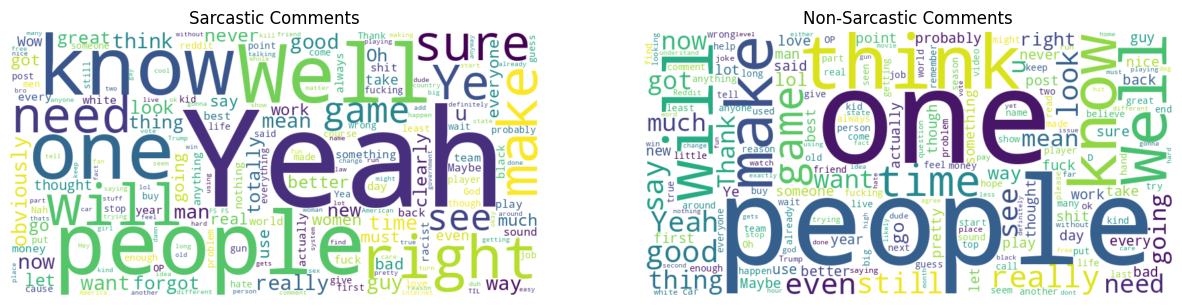

In [26]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter sarcastic and non-sarcastic comments
sarcastic_comments = ' '.join(df[df['label'] == 1]['comment'])
non_sarcastic_comments = ' '.join(df[df['label'] == 0]['comment'])

# Generate word clouds for sarcastic and non-sarcastic comments
wordcloud_sarcastic = WordCloud(width=800, height=400, background_color='white').generate(sarcastic_comments)
wordcloud_non_sarcastic = WordCloud(width=800, height=400, background_color='white').generate(non_sarcastic_comments)

# Plot the word clouds
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_sarcastic, interpolation='bilinear')
plt.title('Sarcastic Comments')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_sarcastic, interpolation='bilinear')
plt.title('Non-Sarcastic Comments')
plt.axis('off')

plt.show()

**Cloud Map for highest occuring words in both(sarcastic & non-sarcastic) the categories after cleaning**

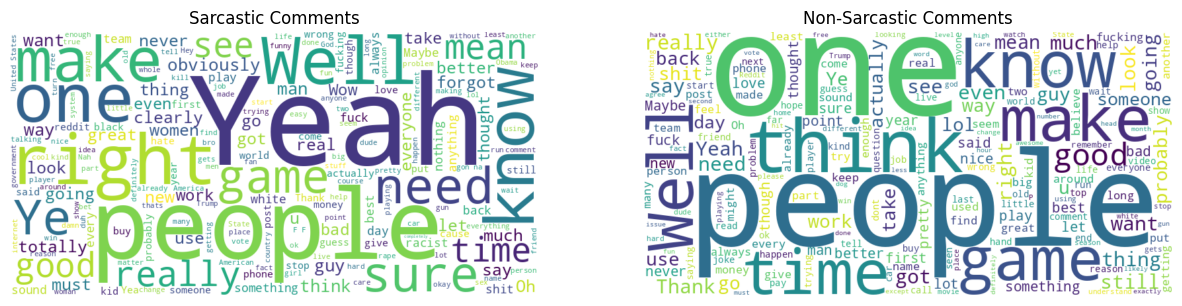

In [27]:
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt

# # Filter sarcastic and non-sarcastic comments
# sarcastic_comments = ' '.join(df[df['label'] == 1]['cleaned_comment'])
# non_sarcastic_comments = ' '.join(df[df['label'] == 0]['cleaned_comment'])

# # Generate word clouds for sarcastic and non-sarcastic comments
# wordcloud_sarcastic = WordCloud(width=800, height=400, background_color='white').generate(sarcastic_comments)
# wordcloud_non_sarcastic = WordCloud(width=800, height=400, background_color='white').generate(non_sarcastic_comments)

# # Plot the word clouds
# plt.figure(figsize=(15, 6))

# plt.subplot(1, 2, 1)
# plt.imshow(wordcloud_sarcastic, interpolation='bilinear')
# plt.title('Sarcastic Comments')
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(wordcloud_non_sarcastic, interpolation='bilinear')
# plt.title('Non-Sarcastic Comments')
# plt.axis('off')

# plt.show()

import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Join lists of words in cleaned_comment column to form strings
sarcastic_comments = ' '.join(df[df['label'] == 1]['cleaned_comment'].apply(lambda x: ' '.join(x)))
non_sarcastic_comments = ' '.join(df[df['label'] == 0]['cleaned_comment'].apply(lambda x: ' '.join(x)))

# Generate word clouds for sarcastic and non-sarcastic comments
wordcloud_sarcastic = WordCloud(width=800, height=400, background_color='white').generate(sarcastic_comments)
wordcloud_non_sarcastic = WordCloud(width=800, height=400, background_color='white').generate(non_sarcastic_comments)

# Plot the word clouds
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_sarcastic, interpolation='bilinear')
plt.title('Sarcastic Comments')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_sarcastic, interpolation='bilinear')
plt.title('Non-Sarcastic Comments')
plt.axis('off')

plt.show()


**GloVe Embedding**

In [28]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 10.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [29]:
import spacy
import numpy as np

# Load SpaCy with GloVe vectors
nlp = spacy.load("en_core_web_md")  # Load the medium-sized English model with GloVe vectors

# Define function to compute average GloVe embeddings for a text
def compute_average_glove_embedding(text, nlp_model):
    doc = nlp_model(' '.join(text))
    # Get vectors for each token in the text
    word_vectors = [token.vector for token in doc if not token.is_stop]
    if word_vectors:
        # Compute average embedding
        average_embedding = np.mean(word_vectors, axis=0)
        return average_embedding
    else:
        # Return zeros if no valid word vectors found
        return np.zeros(nlp_model.vocab.vectors_length)

# Compute average GloVe embeddings for each comment
df['glove_embedding'] = df['cleaned_comment'].apply(lambda x: compute_average_glove_embedding(x, nlp))


In [30]:
df.head(5)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,abbr_comment,detected_abbr,punct_abbr_comment,tokenized_abbr_comment,has_emoji,emoji_replaced_comment,cleaned_comment,glove_embedding
608627,1,And he sure as hell is successful!,armiechedon,1,2015-12-09 23:41:48,Obama's smoked before? Or at least admitted it?,And he sure as hell is successful!,And he sure as hell is successful!,[],And he sure as hell is successful!,"[And, he, sure, as, hell, is, successful, !]",False,"['And', 'he', 'sure', 'as', 'hell', 'is', 'suc...","[sure, hell, successful, !]","[1.116775, 0.205675, -2.4696097, -1.0811, 2.54..."
456977,1,"wait, you have to win the candidates to challe...",killingfeels,1,2016-02-13 00:04:43,You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe...","wait, you have to win the candidates to challe...",[],wait you have to win the candidates to challen...,"[wait, you, have, to, win, the, candidates, to...",False,"['wait', 'you', 'have', 'to', 'win', 'the', 'c...","[wait, win, candidates, challenge, world, titl...","[-1.0515015, 1.8250101, -0.5487285, 0.2253029,..."
803801,1,I mean how could anyone not see that it is ant...,Gnofar,5,2014-12-25 21:59:49,That isn't Hanako?,I mean how could anyone not see that it is ant...,I mean how could anyone not see that it is ant...,[],I mean how could anyone not see that it is ant...,"[I, mean, how, could, anyone, not, see, that, ...",False,"['I', 'mean', 'how', 'could', 'anyone', 'not',...","[mean, could, anyone, not, see, antique, shopguy]","[-1.5973034, -1.8116966, 0.23922665, 0.2648633..."
926708,0,"Funny thing, most of the girl pants I've bough...",smischmal,2,2012-03-05 02:03:43,Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou...","Funny thing, most of the girl pants I have bou...",[],Funny thing most of the girl pants I have boug...,"[Funny, thing, most, of, the, girl, pants, I, ...",False,"['Funny', 'thing', 'most', 'of', 'the', 'girl'...","[Funny, thing, girl, pants, bought, pretty, go...","[-0.82109106, 0.7838919, -2.4705956, -0.6393, ..."
129279,0,"Also Ranch dressing, because LBJ was Texan, an...",ElScreecho,28,2016-09-19 19:20:53,Lyndon Johnson salad: A carrot and 2 beetroots...,"Also Ranch dressing, because LBJ was Texan, an...","Also Ranch dressing, because LBJ was Texan, an...",[LBJ],Also Ranch dressing because LBJ was Texan and ...,"[Also, Ranch, dressing, because, LBJ, was, Tex...",False,"['Also', 'Ranch', 'dressing', 'because', 'LBJ'...","[Also, Ranch, dressing, LBJ, Texan, not, take,...","[-0.14728002, -0.21150999, -0.9164, -1.100585,..."


**lemmetization**

In [31]:
# Load the spaCy English language model
nlp = spacy.load("en_core_web_sm")

def lemma(comment):
    # Join the list of words into a single string
    text = ' '.join(comment)
    # Tokenize the text
    words = word_tokenize(text)
    # Lemmatize and remove stopwords
    cleaned_words = [token.lemma_ for token in nlp(' '.join(words)) if token.text not in stops]
    # Join the cleaned words back into a single string
    cleaned_text = ' '.join(cleaned_words)
    return cleaned_text

# Apply lemmatization
df["lemma_comment"] = df["cleaned_comment"].apply(lemma)


In [32]:
df.tail(20)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,abbr_comment,detected_abbr,punct_abbr_comment,tokenized_abbr_comment,has_emoji,emoji_replaced_comment,cleaned_comment,glove_embedding,lemma_comment
279865,1,"yes Druh, City rules for closing sidewalks and...",Shadow_Ban_Bytes,1,2016-06-23 03:08:58,City of Calgary orders construction site to re...,"yes Druh, City rules for closing sidewalks and...","yes Druh, City rules for closing sidewalks and...",[],yes Druh City rules for closing sidewalks and ...,"[yes, Druh, City, rules, for, closing, sidewal...",False,"['yes', 'Druh', 'City', 'rules', 'for', 'closi...","[yes, Druh, City, rules, closing, sidewalks, a...","[-0.16185999, 0.08407844, 0.27368647, 0.094295...",yes Druh City rule close sidewalk access const...
428182,1,Now max skill her.,Bringerofhars,1,2016-02-13 03:51:34,the hardest evo I've ever done,Now max skill her.,Now max skill her.,[],Now max skill her,"[Now, max, skill, her]",False,"['Now', 'max', 'skill', 'her']","[max, skill]","[1.75, 2.48515, -1.33317, 0.70359504, 0.94373,...",max skill
860368,0,pfft she looks great,LarryLock,-2,2014-01-11 02:53:28,exactly!,pfft she looks great,pfft she looks great,[],pfft she looks great,"[pfft, she, looks, great]",False,"['pfft', 'she', 'looks', 'great']","[pfft, looks, great]","[1.2373034, -0.09863003, -1.9986902, -1.688846...",pfft look great
806833,1,"Oh well if they say the need them, who are we ...",MrCobaltBlue,3,2014-09-29 13:33:47,Why is the Department of Agriculture asking fo...,"Oh well if they say the need them, who are we ...","Oh well if they say the need them, who are we ...",[],Oh well if they say the need them who are we t...,"[Oh, well, if, they, say, the, need, them, who...",False,"['Oh', 'well', 'if', 'they', 'say', 'the', 'ne...","[Oh, well, say, need, question, ?]","[3.4809248, 1.72985, -3.321525, -0.9490025, -0...",oh well say need question ?
426154,1,They're just a bunch of sexists.,flamingboard,80,2016-04-28 03:42:33,I like how they always said Sanders couldn't g...,They are just a bunch of sexists.,They are just a bunch of sexists.,[],They are just a bunch of sexists,"[They, are, just, a, bunch, of, sexists]",False,"['They', 'are', 'just', 'a', 'bunch', 'of', 's...","[bunch, sexists]","[-0.88723, -0.9381499, -0.18062997, -0.0563250...",bunch sexist
657526,0,"Cool, post that story then",OwlEyes312,20,2014-11-14 17:29:47,"So, US sends supplies to fight Ebola.","Cool, post that story then","Cool, post that story then",[],Cool post that story then,"[Cool, post, that, story, then]",False,"['Cool', 'post', 'that', 'story', 'then']","[Cool, post, story]","[2.8891165, -2.78921, 0.55083996, -1.8134999, ...",cool post story
578191,1,RL is basically the batman of e-sports,xPAWNSTAR,2,2015-08-03 09:30:17,RL single-handedly keeping esports on the stra...,RL is basically the batman of e-sports,Real life is basically the batman of e-sports,[RL],Real life is basically the batman of esports,"[Real, life, is, basically, the, batman, of, e...",False,"['Real', 'life', 'is', 'basically', 'the', 'ba...","[Real, life, basically, batman, esports]","[1.12796, 0.756204, -1.0339563, 0.596264, 1.94...",real life basically batman esport
725574,1,"Wow, you're SO confident in yourself and your ...",cry_baby_beluga,4,2015-03-05 15:02:50,Thats if our relationship lasts a year,"Wow, you are SO confident in yourself and your...","Wow, you are Significant other confident in yo...",[SO],Wow you are Significant other confident in you...,"[Wow, you, are, Significant, other, confident,...",False,"['Wow', 'you', 'are', 'Significant', 'other', ...","[Wow, Significant, confident, relationship]","[1.8079752, -0.1302675, -0.21536249, -0.825165...",wow significant confident relationship
946395,0,Perfect fit a Conch Shell,mainec00n,2,2013-08-07 19:12:57,My first 2 oz coin. I don't exactly know where...,Perfect fit a Conch Shell,Perfect fit a Conch Shell,[],Perfect fit a Conch Shell,"[Perfect, fit, a, Conch, Shell]",False,"['Perfect

**TF-IDF Vectorization**

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = df["lemma_comment"]

# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer()
TfIdfMatrix = vectorizer.fit_transform(corpus)
print(TfIdfMatrix)

  (0, 16871)	0.7041111798675871
  (0, 7800)	0.5761797453832763
  (0, 16997)	0.41502330946048965
  (1, 17697)	0.43090657693038836
  (1, 19407)	0.3551323717036828
  (1, 2799)	0.4693200217081363
  (1, 2542)	0.4602183128296239
  (1, 19283)	0.3664692699085339
  (1, 18941)	0.34905388767221573
  (2, 15740)	0.5749750026660426
  (2, 717)	0.552630461804547
  (2, 15411)	0.25589945451669804
  (2, 11948)	0.1482556554969669
  (2, 732)	0.35121040997826597
  (2, 3742)	0.27774071865211825
  (2, 10714)	0.27577235160835395
  (3, 12242)	0.10300814649285027
  (3, 15559)	0.2349346574354589
  (3, 9685)	0.21508439167012716
  (3, 14143)	0.16678992872389264
  (3, 14201)	0.1336818177510647
  (3, 6239)	0.13485079053432325
  (3, 4632)	0.19169112753159426
  (3, 12175)	0.180222123735123
  (3, 18940)	0.24443378463830337
  :	:
  (24993, 14127)	0.728874261323971
  (24993, 19586)	0.684647581737813
  (24994, 4127)	0.6059846761469823
  (24994, 7119)	0.43030679605163896
  (24994, 6808)	0.3634938981674299
  (24994, 8082)	0.

**Concatinating GloVe Embedding Matrices and Tf-Idf Vectors horizontaly to create single feature Matrices**

In [34]:
from scipy.sparse import hstack, csr_matrix
print("GloVe embeddings shape before csr:", df["glove_embedding"].shape)
# Convert the GloVe embeddings to a CSR matrix
glove_embeddings = csr_matrix(np.vstack(df["glove_embedding"].values))

# Print shapes for debugging
print("TfIdfMatrix shape:", TfIdfMatrix.shape)
print("GloVe embeddings after csr shape:", glove_embeddings.shape)

# Combine the TF-IDF matrix and the GloVe embeddings horizontally
combined_matrix = hstack([TfIdfMatrix, csr_matrix(df["glove_embedding"].to_list())])

# Print the shape of the combined matrix
print("Combined matrix shape:", combined_matrix.shape)
print(combined_matrix)

GloVe embeddings shape before csr: (25000,)
TfIdfMatrix shape: (25000, 19808)
GloVe embeddings after csr shape: (25000, 300)
Combined matrix shape: (25000, 20108)
  (0, 16871)	0.7041111798675871
  (0, 7800)	0.5761797453832763
  (0, 16997)	0.41502330946048965
  (0, 19808)	1.1167750358581543
  (0, 19809)	0.20567500591278076
  (0, 19810)	-2.4696097373962402
  (0, 19811)	-1.0810999870300293
  (0, 19812)	2.5414748191833496
  (0, 19813)	2.939802646636963
  (0, 19814)	1.2601025104522705
  (0, 19815)	1.6486749649047852
  (0, 19816)	-2.6000325679779053
  (0, 19817)	1.4555723667144775
  (0, 19818)	0.8994225859642029
  (0, 19819)	0.2915574908256531
  (0, 19820)	-1.5501799583435059
  (0, 19821)	3.6577248573303223
  (0, 19822)	2.2925374507904053
  (0, 19823)	-2.489224910736084
  (0, 19824)	1.2132599353790283
  (0, 19825)	-2.13112735748291
  (0, 19826)	-0.9687325358390808
  (0, 19827)	-1.1257050037384033
  (0, 19828)	2.1764025688171387
  (0, 19829)	0.10024247318506241
  :	:
  (24999, 20083)	1.903599

**Model Implementation Using SVM**

In [35]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Assuming combined_matrix is defined elsewhere
X = combined_matrix  # Features
y = df['label']       # Target variable

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the SVM Classifier
svm_classifier = SVC(kernel='rbf', random_state=42)  # You can choose different kernels like 'rbf', 'poly', etc.

# Train the model on the training set
svm_classifier.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = svm_classifier.predict(X_train)

# Make predictions on the test set
y_test_pred = svm_classifier.predict(X_test)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print accuracies
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# Calculate metrics
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", conf_matrix)


Train Accuracy: 0.758
Test Accuracy: 0.6374
Precision: 0.65748031496063
Recall: 0.5933675483616265
F1-score: 0.6237808673998755
Confusion Matrix:
 [[1684  783]
 [1030 1503]]


**Model Accuracy Improvisation - Iteration 1**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from scipy.stats import reciprocal

# Feature scaling
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the SVM Classifier with RandomizedSearchCV for hyperparameter tuning
svm_classifier = SVC(random_state=42)

# Define the parameter distributions for RandomizedSearchCV
param_dist = {'C': reciprocal(0.01, 100), 'gamma': reciprocal(0.01, 100), 'kernel': ['rbf', 'poly']}

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(svm_classifier, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = random_search.best_params_

# Initialize SVM Classifier with best parameters
best_svm_classifier = SVC(**best_params, random_state=42)

# Train the model on the training set
best_svm_classifier.fit(X_train_scaled, y_train)

# Make predictions on the training set
y_train_pred = best_svm_classifier.predict(X_train_scaled)

# Make predictions on the test set
y_test_pred = best_svm_classifier.predict(X_test_scaled)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print accuracies
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# Calculate metrics
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", conf_matrix)


**Model Tuning - iteration 2**

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from scipy.stats import reciprocal

# Feature scaling
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the SVM Classifier with RandomizedSearchCV for hyperparameter tuning
svm_classifier = SVC(random_state=42)

# Define the parameter distributions for RandomizedSearchCV
param_dist = {'C': reciprocal(0.01, 10), 'gamma': reciprocal(0.01, 10), 'kernel': ['rbf']}

# Perform RandomizedSearchCV with reduced iterations
random_search = RandomizedSearchCV(svm_classifier, param_distributions=param_dist, n_iter=5, cv=3, scoring='accuracy', random_state=42)
random_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = random_search.best_params_

# Initialize SVM Classifier with best parameters
best_svm_classifier = SVC(**best_params, random_state=42)

# Train the model on the training set
best_svm_classifier.fit(X_train_scaled, y_train)

# Make predictions on the training set
y_train_pred = best_svm_classifier.predict(X_train_scaled)

# Make predictions on the test set
y_test_pred = best_svm_classifier.predict(X_test_scaled)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print accuracies
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# Calculate metrics
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", conf_matrix)
